In [189]:
from alfalfa import AlfalfaTree, AlfalfaForest
from alfalfa.tree_models.tree_kernels import AlfalfaGP
from alfalfa.tree_models.forest import DecisionNode
from alfalfa.fitting.bart.bart import BART
from alfalfa.fitting.bart.data import Data
from alfalfa.leaf_gp.space import Space, Dimension
from alfalfa.fitting.bart.params import BARTTrainParams
from alfalfa.utils.plots import plot_gp_1d, plot_covar_matrix

import math
import torch
import numpy as np
import gpytorch as gpy
from matplotlib import pyplot as plt
from pathlib import Path
import scipy.stats as stats

In [190]:
# data
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 10).reshape(-1, 1)
# train_x = torch.tensor([0.1, 0.3, 0.4, 0.9]).reshape(-1, 1)
space = Space([[0.0, 1.0]])

# True function is sin(2*pi*x) with Gaussian noise
torch.manual_seed(42)
np.random.seed(42)
f = lambda x: torch.sin(x * (2 * math.pi))
train_y = (f(train_x) + torch.randn(train_x.size()) * 0.2).flatten()
data = Data(space, train_x)


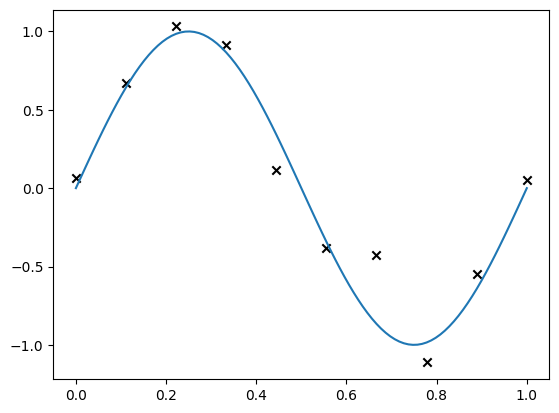

In [191]:
test_x = torch.linspace(0, 1, 100)
plt.scatter(train_x, train_y, color="black", marker="x")
plt.plot(test_x, f(test_x))

In [192]:
def fit_gp(x, y, model, likelihood):
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpy.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter:=500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(x)
        # Calc loss and backprop gradients
        loss = -mll(output, y)
        loss.backward()
        if i % 100 == -1:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  scale:%.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.kernels[0].lengthscale.item(),
                # model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item(),
                model.covar_module.outputscale.item(),
                model.covar_module.outputscale.item()
            ))
        optimizer.step()


In [193]:
# from alfalfa.baselines import RBFGP

class ConstantKernel(gpy.kernels.Kernel):
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, x1: torch.Tensor, x2: torch.Tensor, diag=False, **params):
        if diag:
            return torch.ones(x1.shape[0])
        return torch.ones((x1.shape[0], x2.shape[0])) * self.p


class RBFGP(gpy.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood, p):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpy.means.ZeroMean()

        self.covar_module = gpy.kernels.ScaleKernel(gpy.kernels.RBFKernel()) + gpy.kernels.ScaleKernel(ConstantKernel(p))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpy.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpy.likelihoods.GaussianLikelihood()
gp = RBFGP(train_x, train_y, likelihood, p=1.0)

In [194]:
fit_gp(train_x, train_y, gp, gp.likelihood)

In [195]:
gp.covar_module.kernels[1].outputscale
gp.covar_module.kernels[0].base_kernel.lengthscale
# gp.covar_module.kernels[0].outputscale, gp.covar_module.kernels[1].outputscale


tensor([[0.1470]], grad_fn=<SoftplusBackward0>)

In [196]:
noise = gp.likelihood.noise * torch.eye(train_x.shape[0])
- train_y.reshape(1, -1) @ (gp.covar_module(train_x, train_x) + noise) @ train_y.reshape(-1, 1)

tensor([[-3.3607]], grad_fn=<MmBackward0>)

In [197]:
- torch.logdet(gp.covar_module(train_x, train_x) + noise)

tensor(16.8146, grad_fn=<NegBackward0>)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

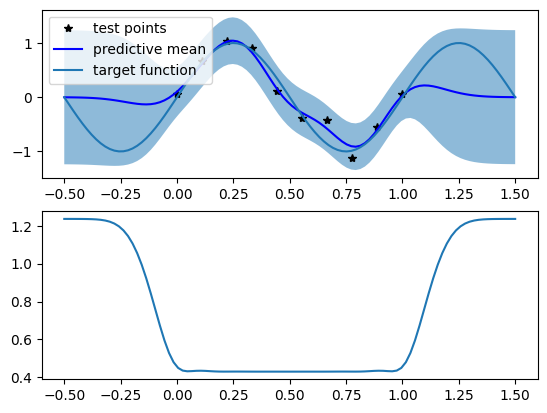

In [198]:
gp.eval()
test_x = torch.linspace(-0.5, 1.5, 100)
plot_gp_1d(gp, test_x, f)

In [199]:
import numpy as np
u = 
np.array([[1.0, 1.0, -1.0]]).T @ np.array([])

SyntaxError: invalid syntax (358003921.py, line 2)